In [48]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jit
import jax
from functools import partial

a = 2 # 2aB
nH = 2
atoms = ""
for i in range(nH):
    atoms += f"N {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="sto6g", unit='B', spin=0, verbose=4)
mol.build()

mf = scf.UHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

et = mycc.ccsd_t()

System: uname_result(system='Linux', node='sharmagroup-rn', release='6.14.0-37-generic', version='#37~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 10:25:38 UTC 2', machine='x86_64')  Threads 16
Python 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
numpy 2.3.1  scipy 1.16.2  h5py 3.14.0
Date: Tue Feb  3 16:06:46 2026
PySCF version 2.11.0
PySCF path  /home/sharmagroup/sharmagroup/pyscf
GIT HEAD (branch master) 3d1768f5e33b144b606c3d2c81c12ee54d794501

[ENV] PYSCF_EXT_PATH /home/sharmagroup/sharmagroup/pyscf-forge
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 14
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = B
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr 

In [49]:
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'uhf',
            'trial': 'uhf',
            'free_projection': True,
            'dt':0.01,
            'use_gpu': False
            }

from ad_afqmc import pyscf_interface
pyscf_interface.prep_afqmc(mycc,options,chol_cut=1e-5)

option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (7, 7)
# Number of basis functions: 10
# Number of Cholesky vectors: 42
#


In [3]:
import numpy as np
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config
from ad_afqmc import mpi_jax

# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64


In [50]:
config.setup_jax()
MPI = config.setup_comm()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print = partial(print, flush=True)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (mpi_jax._prep_afqmc())

# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 10
# nelec: (7, 7)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 50
# seed: 2
# walker_type: uhf
# trial: uhf
# free_projection: True
# dt: 0.01
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#


In [ ]:
from ad_afqmc import linalg_utils
from jax import lax
import jax
from jax import numpy as jnp

@jit
def uwalker_norm(
    walker_up: jax.Array,
    walker_dn: jax.Array,
) -> float:
    norm = jnp.linalg.det(walker_up.T.conj() @ walker_up
        ) * jnp.linalg.det(walker_dn.T.conj() @ walker_dn)
    return jnp.real(norm)


@jit
def qr_walker_uhf(walker_up, walker_dn):
    nocc_up = walker_up.shape[1]
    nocc_dn = walker_dn.shape[1]
    q_up, r_up = jnp.linalg.qr(walker_up)
    q_dn, r_dn = jnp.linalg.qr(walker_dn)
    norm_up = jnp.sqrt(
        jnp.real(
            jnp.linalg.det(r_up[:,:nocc_up].conj().T @ r_up[:,:nocc_up])
            )
        )
    norm_dn = jnp.sqrt(
        jnp.real(
            jnp.linalg.det(r_dn[:,:nocc_dn].conj().T @ r_dn[:,:nocc_dn])
            )
        )
    return (q_up, q_dn), norm_up * norm_dn

def qr_walkers_uhf(walkers):
    (walkers_up, walkers_dn), norms \
        = vmap(qr_walker_uhf, in_axes=(0, 0))(walkers[0], walkers[1])
    return (walkers_up, walkers_dn), norms

@jit
def stochastic_reconfiguration_uhf(walkers, weights, zeta):
    nwalkers = walkers[0].shape[0]
    cumulative_weights = jnp.cumsum(jnp.abs(weights))
    total_weight = cumulative_weights[-1]
    average_weight = total_weight / nwalkers
    weights = jnp.ones(nwalkers, dtype=jnp.complex128) * average_weight
    z = total_weight * (jnp.arange(nwalkers) + zeta) / nwalkers
    indices = vmap(jnp.searchsorted, in_axes=(None, 0))(cumulative_weights, z)
    walkers[0] = walkers[0][indices]
    walkers[1] = walkers[1][indices]
    return walkers, weights

@partial(jit, static_argnums=(0))
def my_propagate_free(prop, ham_data, prop_data, fields):
    shift_term = jnp.einsum("wg,g->w", fields, ham_data["mf_shifts"])
    constants = jnp.exp(-jnp.sqrt(prop.dt) * shift_term # exp(-sqrt(t) x_g mf_g)
                ) * jnp.exp(prop.dt * (ham_data["h0_prop"]) + prop_data["e_estimate"])
    constants_abs = jnp.abs(constants)
    phase = constants / constants_abs
    prop_data["weights"] *= constants_abs # keep the weight (norm of the walker) real
    prop_data["walkers"] = prop._apply_trotprop(ham_data, prop_data["walkers"], fields)
    nocca, noccb = prop_data["walkers"][0].shape[-1], prop_data["walkers"][1].shape[-1]
    phase_mo = jnp.stack((phase**(1/(2.0*nocca)), phase**(1/(2.0*noccb)))) # multiply the phase into the mo_coeff
    prop_data["walkers"] = prop._multiply_constant(prop_data["walkers"], phase_mo)
    return prop_data

@partial(jit, static_argnums=(0))
def propagate_free(prop, ham_data, prop_data, fields):
    shift_term = jnp.einsum("wg,sg->sw", fields, ham_data["mf_shifts_fp"])
    constants = jnp.einsum(
        "sw,s->sw",
        jnp.exp(-jnp.sqrt(prop.dt) * shift_term),
        jnp.exp(prop.dt * ham_data["h0_prop_fp"]),
    )
    prop_data["walkers"] = prop._apply_trotprop(
        ham_data, prop_data["walkers"], fields
    )
    prop_data["walkers"] = prop._multiply_constant(prop_data["walkers"], constants)
    
    # prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    # weights = jnp.abs(jnp.real(norms[0] * norms[1]))
    # weights = jnp.real(norms[0] * norms[1])
    # nwalker = int(prop_data["weights"].shape[0])
    # prop_data["weights"] *= weights
    # prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    # prop_data["weights"] *= prop_data["overlaps"]
    # prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data


# @partial(jit, static_argnums=(3))
# def fp_step(prop_data, fields, ham_data, prop):
#     """A Free propagation step of nwalkers"""
#     prop_data = propagate_free(prop, ham_data, prop_data, fields)
#     return prop_data, fields

# @partial(jit, static_argnums=(3))
# def fp_step_qr(prop_data, fields, ham_data, prop):
#     """A Free propagation step of nwalkers"""
#     prop_data = propagate_free(prop, ham_data, prop_data, fields)
#     (prop_data["walkers"][0], prop_data["walkers"][1]), norms \
#         = qr_walkers_uhf(prop_data["walkers"])
#     nwalker = int(prop_data["weights"].shape[0])
#     prop_data["weights"] *= norms 
#     prop_data["weights"] /= nwalker * jnp.sum(prop_data["weights"])
#     return prop_data, fields

@partial(jit, static_argnums=(3))
def fp_step_qr(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    weights = norms[0] * norms[1]
    # weights = jnp.real(norms[0] * norms[1])
    nwalker = int(prop_data["weights"].shape[0])
    prop_data["weights"] *= jnp.real(weights)
    prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    return prop_data, fields

@partial(jit, static_argnums=(3))
def my_fp_step_qr(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = my_propagate_free(prop, ham_data, prop_data, fields)
    prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    norms = norms[0] * norms[1]
    norms_abs = jnp.abs(norms)
    phase = norms / norms_abs
    # weights = jnp.real(norms[0] * norms[1])
    nwalker = int(prop_data["weights"].shape[0])
    prop_data["weights"] *= norms_abs
    prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    nocca, noccb = prop_data["walkers"][0].shape[-1], prop_data["walkers"][1].shape[-1]
    phase_mo = jnp.stack((phase**(1/(2.0*nocca)), phase**(1/(2.0*noccb)))) # multiply the phase into the mo_coeff
    prop_data["walkers"] = prop._multiply_constant(prop_data["walkers"], phase_mo)
    return prop_data, fields

@partial(jit, static_argnums=(3))
def fp_step_sr(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    norms = norms[0] * norms[1]
    norms_abs = jnp.abs(norms)
    phase = norms / norms_abs
    # weights = jnp.real(norms[0] * norms[1])
    nwalker = int(prop_data["weights"].shape[0])
    prop_data["weights"] *= norms_abs
    prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    nocca, noccb = prop_data["walkers"][0].shape[-1], prop_data["walkers"][1].shape[-1]
    phase_mo = jnp.stack((phase**(1/(2.0*nocca)), phase**(1/(2.0*noccb)))) # multiply the phase into the mo_coeff
    prop_data["walkers"] = prop._multiply_constant(prop_data["walkers"], phase_mo)

    # sr
    prop_data = prop.stochastic_reconfiguration_local(prop_data)
    # prop_data["key"], subkey = random.split(prop_data["key"])
    # zeta = random.uniform(subkey)
    # prop_data["walkers"], prop_data["weights"] \
    #     = stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)

    return prop_data, fields

@partial(jit, static_argnums=(3))
def myfp_step_sr(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = my_propagate_free(prop, ham_data, prop_data, fields)
    prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    norms = norms[0] * norms[1]
    norms_abs = jnp.abs(norms)
    phase = norms / norms_abs
    # weights = jnp.real(norms[0] * norms[1])
    nwalker = int(prop_data["weights"].shape[0])
    prop_data["weights"] *= norms_abs
    prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    nocca, noccb = prop_data["walkers"][0].shape[-1], prop_data["walkers"][1].shape[-1]
    phase_mo = jnp.stack((phase**(1/(2.0*nocca)), phase**(1/(2.0*noccb)))) # multiply the phase into the mo_coeff
    prop_data["walkers"] = prop._multiply_constant(prop_data["walkers"], phase_mo)
    
    # sr
    prop_data = prop.stochastic_reconfiguration_local(prop_data)
    # prop_data["key"], subkey = random.split(prop_data["key"])
    # zeta = random.uniform(subkey)
    # prop_data["walkers"], prop_data["weights"] \
    #     = stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)
    return prop_data, fields


@partial(jit, static_argnums=(2, 3, 5))
def fp_block_qr(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_qr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * prop_data["weights"] * prop_data["overlaps"] 
        ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def my_fp_block_qr(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: my_fp_step_qr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * prop_data["weights"] * prop_data["overlaps"] 
        ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    return prop_data, (block_energy, block_weight)

@partial(jit, static_argnums=(2, 3, 5))
def fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_sr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    
    block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    
    block_energy = jnp.sum(
        energy_samples * prop_data["weights"] * prop_data["overlaps"] 
        ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )

    return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def myfp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: myfp_step_sr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    
    block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    
    block_energy = jnp.sum(
        energy_samples * prop_data["weights"] * prop_data["overlaps"] 
        ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )

    return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def myfp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: myfp_step_sr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    
    block_weight = jnp.sum(prop_data["weights"] * jnp.abs(prop_data["overlaps"]))
    
    block_energy = jnp.sum(
        energy_samples * prop_data["weights"] * jnp.abs(prop_data["overlaps"])
        ) / jnp.sum(prop_data["weights"] * jnp.abs(prop_data["overlaps"]))

    return prop_data, (block_energy, block_weight)

In [52]:
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

def init_prop(prop, trial, wave_data, ham_data, seed, init_walkers=None):
    prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
    # if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    #     raise ValueError(
    #         "Initial overlaps are zero. Pass walkers with non-zero overlap."
    #     )
    # prop_data["weights"] = jnp.ones(prop.n_walkers,dtype=jnp.complex128)
    prop_data["weights"] = jnp.ones(prop.n_walkers)
    prop_data["key"] = random.PRNGKey(seed)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    prop_data["n_killed_walkers"] = 0
    return prop_data

prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["e_estimate"])

-108.52346313844824


In [53]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
nstep = 60
fp_qr_e = np.zeros(nstep+1,dtype=np.complex128)
fp_qr_w = np.zeros(nstep+1,dtype=np.complex128)
fp_qr_e[0] = prop_data["e_estimate"]
fp_qr_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_qr(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_qr_e[n+1] = blk_e
    fp_qr_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.62324062413079-0.0001202707662104458j) (65.7184264635155-0.44422724673126784j)
2 (-108.64349735006208+0.008895050790925311j) (60.69391707859755+0.6866305590539323j)
3 (-108.62420820004714+0.0001208746541664695j) (1138.8533477363485-4.401903081785901j)
4 (-108.63583915314696+0.0036786119076432705j) (76.61402259935146-0.5356058462211888j)
5 (-108.62650496371583-0.001633722330798522j) (48.45906528983436+0.3317351053089026j)
6 (-108.64883001141595+2.2090375686159306e-05j) (89.47959831879169+0.5978038306370485j)
7 (-108.65901464421735-0.006627651945608081j) (-704.2332808319796+5.578182678754574j)
8 (-108.63513399003715+0.012071587794695965j) (100.70988325329316+1.2023192612738358j)
9 (-108.65315671930472+0.015107360741931612j) (224.5904591815202+3.8586456620378438j)
10 (-108.72656988651354-0.022328083933500945j) (-300.34781807834736+2.402600646833029j)
11 (-108.67776755474426-0.02538719642836227j) (-108.97204703853401-1.1220749788421056j)
12 (-108.65630625896904-0.013857020874439529

In [54]:
prop_data["weights"]

Array([-1.78470599e+00,  2.78089501e-03,  4.22963106e-01, -2.63595127e-01,
       -2.10504050e-01,  4.23076031e-01, -6.10344425e-05, -2.50276560e-02,
       -6.83374716e-03, -2.31991802e-04,  1.85931408e-05,  1.79196767e-03,
        2.87802249e-01,  2.48145432e+00,  3.96168474e+00, -1.18430371e-02,
        1.28793949e+00,  5.71108492e-02, -3.30293645e-06, -1.57175768e-03,
       -3.09461486e-02,  8.77991130e-04,  2.17767725e-04, -4.26769011e-02,
       -2.77313630e-01,  6.96732840e-04,  1.70302800e-02,  4.60444924e-01,
       -4.16642323e-04,  3.36385263e-03,  2.55334463e+01, -1.70681203e+01,
       -2.50792904e-04,  1.68112634e-04,  2.14313316e-02,  1.74061085e-04,
       -1.21607565e-02,  2.53851831e+00,  2.01997111e-02,  1.89939732e+01,
       -2.96183412e-03,  1.03466354e+01,  1.12272136e-04, -2.77137093e-02,
        1.94309720e-01,  2.92222065e+00,  9.83796963e-03, -3.00701037e-02,
       -1.93435761e-01,  1.63446390e-04], dtype=float64)

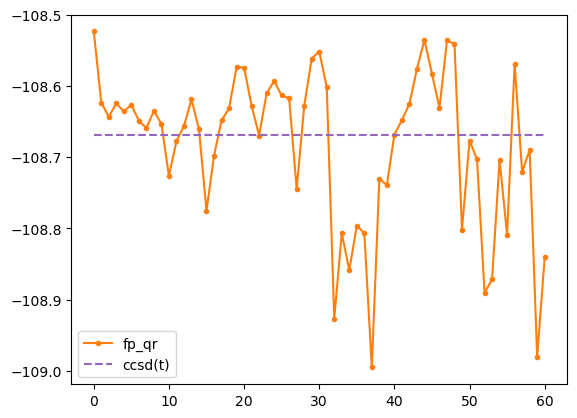

In [55]:
from matplotlib import pyplot as plt

# plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_qr_e.real,'.-',label='fp_qr',color='C1')
plt.plot([mycc.e_tot + et]*len(fp_qr_e), '--',label='ccsd(t)',color='C4')
plt.legend()
plt.show()

In [56]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
nstep = 60
myfp_qr_e = np.zeros(nstep+1,dtype=np.complex128)
myfp_qr_w = np.zeros(nstep+1,dtype=np.complex128)
myfp_qr_e[0] = prop_data["e_estimate"]
myfp_qr_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        my_fp_block_qr(prop_data, ham_data, prop, trial, wave_data, sampler)
    myfp_qr_e[n+1] = blk_e
    myfp_qr_w[n+1] = blk_w

    print(n+1, blk_e, blk_w)

1 (-108.6232406241308-0.00012027076621137763j) (34.43256653587586-0.2327487898484222j)
2 (-108.64349735006209+0.008895050790924942j) (28.956219421920895+0.3275818415873244j)
3 (-108.62420820004714+0.00012087465416633034j) (28.38409233683208-0.10971037120778601j)
4 (-108.63583915314696+0.003678611907644711j) (26.131157369828394-0.18268197101477782j)
5 (-108.6265049637158-0.0016337223307987256j) (24.212990908830683+0.16575431327310503j)
6 (-108.64883001141595+2.2090375685865054e-05j) (23.65441137287927+0.15803264650075943j)
7 (-108.65901464421736-0.0066276519456071785j) (22.216575790822986-0.17597594665141003j)
8 (-108.6351339900371+0.012071587794695183j) (23.464832154619955+0.2801335752823655j)
9 (-108.65315671930469+0.015107360741930255j) (23.457191719685277+0.40301351803866675j)
10 (-108.7265698865135-0.022328083933503346j) (19.732637032935695-0.15784914570875597j)
11 (-108.67776755474426-0.02538719642835835j) (19.38226792670701+0.19957740048729106j)
12 (-108.65630625896902-0.01385702

In [57]:
prop_data["weights"]

Array([9.91713917e-01, 1.54526981e-03, 2.35029411e-01, 1.46472840e-01,
       1.16971533e-01, 2.35092161e-01, 3.39152254e-05, 1.39072065e-02,
       3.79733256e-03, 1.28911709e-04, 1.03317166e-05, 9.95749042e-04,
       1.59924098e-01, 1.37887854e+00, 2.20140343e+00, 6.58086248e-03,
       7.15673914e-01, 3.17349885e-02, 1.83535443e-06, 8.73384172e-04,
       1.71959563e-02, 4.87876450e-04, 1.21007765e-04, 2.37144253e-02,
       1.54095850e-01, 3.87156012e-04, 9.46327620e-03, 2.55857066e-01,
       2.31517120e-04, 1.86920394e-03, 1.41882608e+01, 9.48430305e+00,
       1.39358984e-04, 9.34157445e-05, 1.19088242e-02, 9.67211416e-05,
       6.75741074e-03, 1.41058749e+00, 1.12244452e-02, 1.05544486e+01,
       1.64581289e-03, 5.74935164e+00, 6.23866567e-05, 1.53997753e-02,
       1.07972772e-01, 1.62380073e+00, 5.46669953e-03, 1.67091613e-02,
       1.07487137e-01, 9.08228363e-05], dtype=float64)

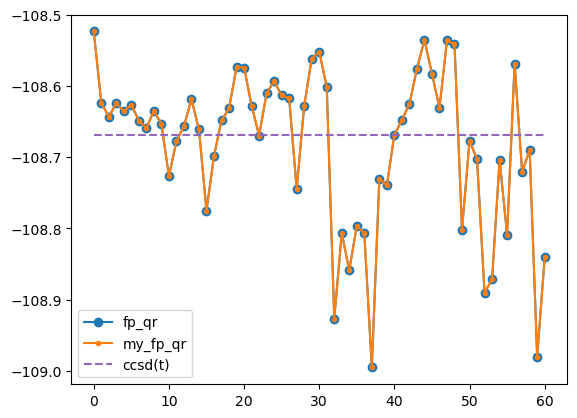

In [58]:
from matplotlib import pyplot as plt
plt.plot(fp_qr_e.real,'o-',label='fp_qr',color='C0')
plt.plot(myfp_qr_e.real,'.-',label='my_fp_qr',color='C1')
plt.plot([mycc.e_tot + et]*len(fp_qr_e), '--',label='ccsd(t)',color='C4')
plt.legend()
plt.show()

In [59]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
nstep = 60
fp_sr_e = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_w = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_e[0] = prop_data["e_estimate"]
fp_sr_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_sr_e[n+1] = blk_e
    fp_sr_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.62055796785098-0.0002365187545194754j) (34.758989136975515-0.13219438198297895j)
2 (-108.64289621193687+0.006691494762408547j) (30.15880578781559-0.13678838377790542j)
3 (-108.64702869314677-0.0021093447185697653j) (27.6750052388091-0.6673407085866854j)
4 (-108.71984559988007+0.0029804859512967538j) (22.4936497087603-0.6442217393877858j)
5 (-108.70355507585654-0.004105239041494196j) (21.406877047380487-0.6398255605991621j)
6 (-108.63606641690224-0.011827318027099734j) (21.971106564727997-0.7371952598560222j)
7 (-108.66323181757451+0.008235061960173422j) (20.050353207863058-0.6652346606325319j)
8 (-108.65019028914176+0.009451650848544083j) (19.749552768811732-0.9814048320933613j)
9 (-108.65880133086742+0.014123199585901077j) (18.75961359721923-0.25546691134153177j)
10 (-108.64346304156886-0.007185221683775706j) (17.510512011079378-0.8069355758480556j)
11 (-108.70462698584082-0.015687264267226875j) (17.30764414099818-0.8053284853467495j)
12 (-108.66216123695295+0.0005603156769318

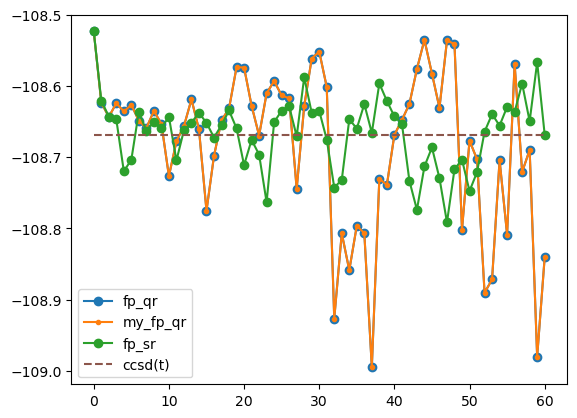

In [60]:
plt.plot(fp_qr_e.real,'o-',label='fp_qr',color='C0')
plt.plot(myfp_qr_e.real,'.-',label='my_fp_qr',color='C1')
plt.plot(fp_sr_e.real,'o-',label='fp_sr',color='C2')
plt.plot([mycc.e_tot + et]*len(fp_qr_e), '--',label='ccsd(t)',color='C5')
plt.legend()
plt.show()

In [61]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
nstep = 60
myfp_sr_e = np.zeros(nstep+1,dtype=np.complex128)
myfp_sr_w = np.zeros(nstep+1,dtype=np.complex128)
myfp_sr_e[0] = prop_data["e_estimate"]
myfp_sr_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        myfp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler)
    myfp_sr_e[n+1] = blk_e
    myfp_sr_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.62055796785098-0.00023651875451965565j) (34.7589891369755-0.13219438198297495j)
2 (-108.64289621193684+0.006691494762408461j) (30.1588057878156-0.13678838377794222j)
3 (-108.64702869314681-0.0021093447185712676j) (27.67500523880909-0.6673407085867353j)
4 (-108.71984559988009+0.002980485951296363j) (22.493649708760294-0.644221739387819j)
5 (-108.70355507585654-0.00410523904149417j) (21.406877047380505-0.6398255605992097j)
6 (-108.6360664169023-0.01182731802710179j) (21.97110656472801-0.7371952598560537j)
7 (-108.66323181757453+0.008235061960173692j) (20.050353207863047-0.6652346606325703j)
8 (-108.65019028914173+0.009451650848543719j) (19.749552768811725-0.9814048320934077j)
9 (-108.65880133086742+0.014123199585895857j) (18.75961359721923-0.2554669113415903j)
10 (-108.64346304156888-0.007185221683784344j) (17.510512011079374-0.8069355758480976j)
11 (-108.70462698584083-0.015687264267228294j) (17.307644140998185-0.8053284853468162j)
12 (-108.66216123695291+0.0005603156769394261j)

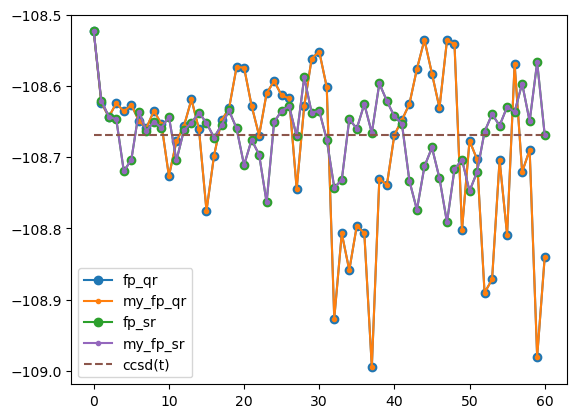

In [62]:
plt.plot(fp_qr_e.real,'o-',label='fp_qr',color='C0')
plt.plot(myfp_qr_e.real,'.-',label='my_fp_qr',color='C1')
plt.plot(fp_sr_e.real,'o-',label='fp_sr',color='C2')
plt.plot(myfp_sr_e.real,'.-',label='my_fp_sr',color='C4')
plt.plot([mycc.e_tot + et]*len(fp_qr_e), '--',label='ccsd(t)',color='C5')
plt.legend()
plt.show()

In [64]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
nstep = 60
myfp_abs_e = np.zeros(nstep+1,dtype=np.complex128)
myfp_abs_w = np.zeros(nstep+1,dtype=np.complex128)
myfp_abs_e[0] = prop_data["e_estimate"]
myfp_abs_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        myfp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler)
    myfp_abs_e[n+1] = blk_e
    myfp_abs_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.62039862587723-0.00010480189535574385j) 34.77575430885559
2 (-108.64171167934023+0.006149017826659594j) 30.206856957114105
3 (-108.6435278732611-0.007645244861326027j) 27.844500747107254
4 (-108.70701645680862-0.010415020788720955j) 22.939013818884344
5 (-108.68860973279467-0.018566285797758538j) 22.25174134093825
6 (-108.6223340930975-0.008978578536356238j) 23.133641305906902
7 (-108.64460875741624+0.0006800437981152841j) 21.96290570304545
8 (-108.62810948815145-0.0028738071879036674j) 21.729687132936448
9 (-108.64201017825893+0.0008623329200564207j) 20.7281749634656
10 (-108.62382130063948-0.0010010885230479565j) 19.733614432276738
11 (-108.67212627620242-0.010178828843960297j) 19.862695667225395
12 (-108.64408492896968-0.002757383999773793j) 21.756630910058973
13 (-108.62353335344687-0.01452717346049343j) 22.556348017278566
14 (-108.62975220662486-0.009495735574705948j) 22.415945543695003
15 (-108.6374050274854-0.01300565566270927j) 22.487944562497084
16 (-108.67990511784379

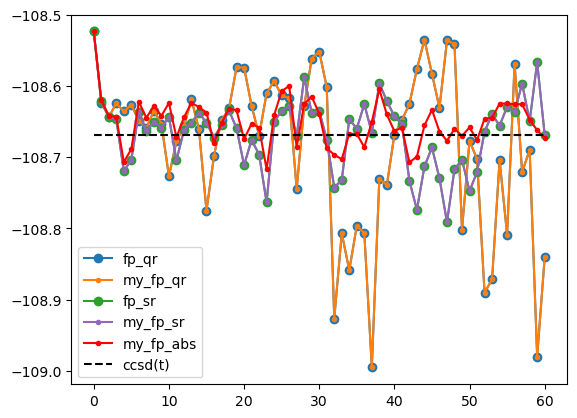

In [67]:
plt.plot(fp_qr_e.real,'o-',label='fp_qr',color='C0')
plt.plot(myfp_qr_e.real,'.-',label='my_fp_qr',color='C1')
plt.plot(fp_sr_e.real,'o-',label='fp_sr',color='C2')
plt.plot(myfp_sr_e.real,'.-',label='my_fp_sr',color='C4')
plt.plot(myfp_abs_e.real,'.-',label='my_fp_abs',color='red')
plt.plot([mycc.e_tot + et]*len(fp_qr_e), '--',label='ccsd(t)',color='black')
plt.legend()
plt.show()